In [1]:
from parser import get_files_in_folder, parse_gene_sequences
from damerau_levenshtein import damerau_levenshtein
from gen_algo import crossover, mutate

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

import os, sys

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from keras.utils import to_categorical

In [41]:
dataset = pd.read_csv('dataset copy.csv', sep=';')

x = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

In [42]:
pca = PCA(n_components=0.95)
x_pca = pca.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_pca)

In [49]:
# implementing silhoutte score
params = [2, 3, 4, 5, 6, 7, 8, 9, 10]
paramGrid = ParameterGrid({'n_clusters': params})

best_score = -1

silhouette_scores = []

kmeans = KMeans()

for p in paramGrid:
	kmeans.set_params(**p)
	kmeans.fit(x_pca)

	silScore = silhouette_score(x_pca, kmeans.labels_, random_state=0)
	silhouette_scores.append(silScore)

	print('Parameter: ', p, 'Score: ', silScore)

	if silScore > best_score:
		best_score = silScore
		best_grid = p

Parameter:  {'n_clusters': 2} Score:  0.8424599222595418
Parameter:  {'n_clusters': 3} Score:  0.8278973495084748
Parameter:  {'n_clusters': 4} Score:  0.9300099038190928
Parameter:  {'n_clusters': 5} Score:  0.9332107846087592
Parameter:  {'n_clusters': 6} Score:  0.9337255049482558
Parameter:  {'n_clusters': 7} Score:  0.9527206792711953
Parameter:  {'n_clusters': 8} Score:  0.952688588016981
Parameter:  {'n_clusters': 9} Score:  0.9578199383899024
Parameter:  {'n_clusters': 10} Score:  0.9574155799278163


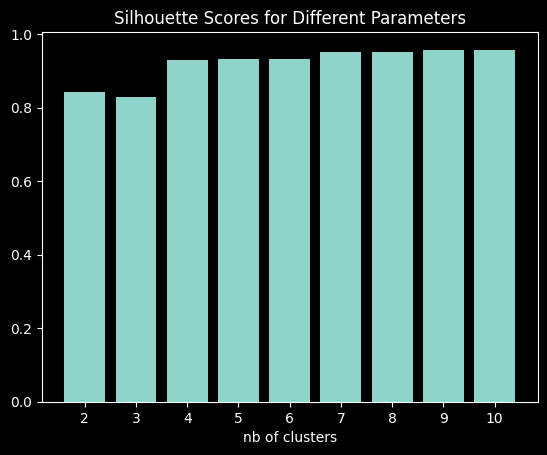

In [50]:

# plot the silhouette scores
plt.bar(range(len(silhouette_scores)), silhouette_scores, tick_label=list(params))
plt.xticks(range(len(silhouette_scores)), params)
plt.title('Silhouette Scores for Different Parameters')
plt.xlabel('nb of clusters')

plt.show()

Best grid:  9 Best score:  0.9578199383899024


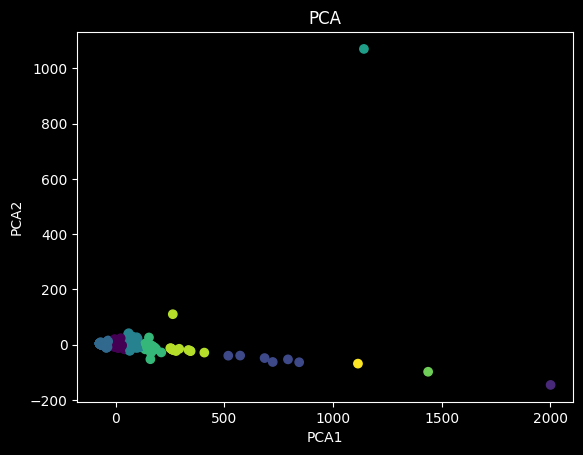

In [ ]:
print('Best grid: ', best_grid['n_clusters'], 'Best score: ', best_score)

y_pred = KMeans(n_clusters=best_grid['n_clusters'], random_state=0).fit_predict(x_pca)

km = KMeans(n_clusters=best_grid['n_clusters'], random_state=0).fit(x_pca)
y_kmeans = km.predict(x_pca)

# ax = plt.gca()
# ax.set_xlim([-20, 50])
# ax.set_ylim([-30, 20])

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=kmeans.labels_)

plt.title('PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

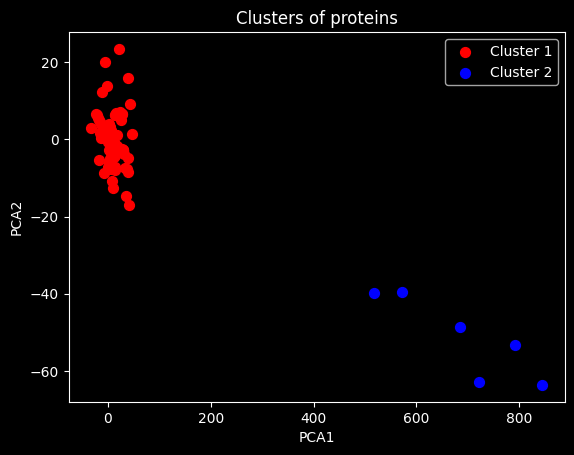

In [52]:
# ax = plt.gca()
# ax.set_xlim([-200, 450])
# ax.set_ylim([-100, 80])

plt.scatter(x_pca[y_kmeans == 0, 0], x_pca[y_kmeans == 0, 1], s=50, c='red', label='Cluster 1')
plt.scatter(x_pca[y_kmeans == 1, 0], x_pca[y_kmeans == 1, 1], s=50, c='blue', label='Cluster 2')
# name the axes
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters of proteins')
plt.legend()

plt.show()

Max number of clusters found by HDBSCAN:  118


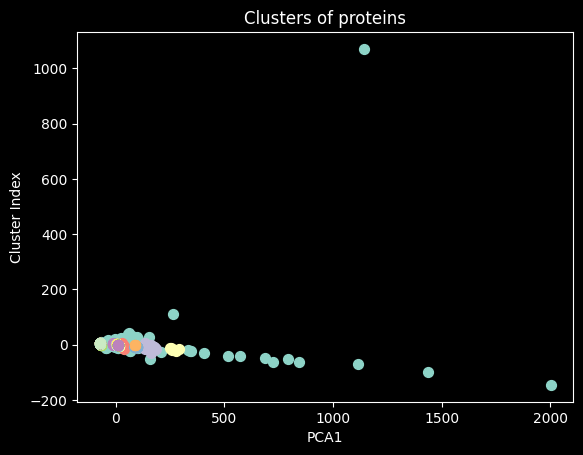

In [48]:
hdb = HDBSCAN()
hdb.fit(x_pca)
hdb_labels = hdb.labels_

# print max number of clusters found by HDBSCAN
print('Max number of clusters found by HDBSCAN: ', len(np.unique(hdb_labels)))

# ax = plt.gca()
# ax.set_ylim([-10, 20])
# ax.set_xlim([-10, 20])

for i in np.unique(hdb_labels):
	plt.scatter(x_pca[hdb_labels == i, 0], x_pca[hdb_labels == i, 1], s=50, label='Cluster ' + str(i))

plt.title('Clusters of proteins')
plt.xlabel('PCA1')
plt.ylabel('Cluster Index')

# plt.legend()
plt.show()

In [ ]:
# Définir un modèle autoencodeur pour le clustering
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_pca.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(x_pca.shape[1], activation='sigmoid'))

# Compiler le modèle avec une fonction de perte adaptée
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()
                                                                       
# Entraînement du modèle (Autoencodeur)
history = model.fit(x_pca, x_pca, epochs=100, batch_size=16, verbose=0)

# Afficher l'évolution de la fonction de perte
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

# Afficher l'évolution de la précision
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                30272     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 472)               30680     
                                                                 
Total params: 66216 (258.66 KB)
Trainable params: 6621

KeyboardInterrupt: 

In [ ]:
# clustering
encoder = Sequential()
encoder.add(model.layers[0])
encoder.add(model.layers[1])
encoder.add(model.layers[2])

X_encoded = encoder.predict(x_pca)

221/221 [==============================] - 0s 987us/step


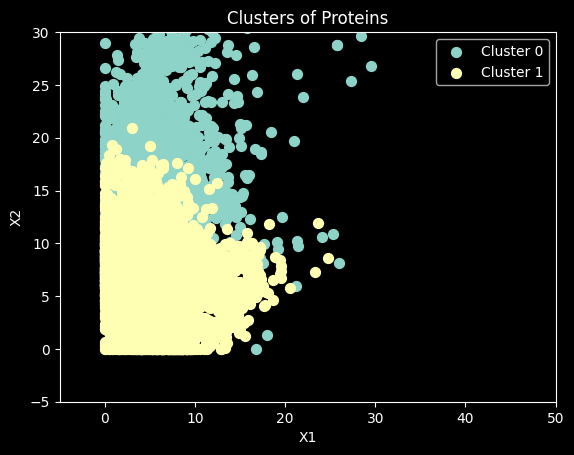

In [ ]:
# clustering
kmeans = KMeans(n_clusters=2, random_state=0)
y_pred = kmeans.fit_predict(X_encoded)

ax = plt.gca()
ax.set_xlim([-5, 50])
ax.set_ylim([-5, 30])

# Afficher les résultats du clustering
for i in range(2):
	plt.scatter(X_encoded[y_pred == i, 0], X_encoded[y_pred == i, 1], s=50, label='Cluster ' + str(i))

plt.title('Clusters of Proteins')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()

plt.show()

Max number of clusters found by DBSCAN:  63


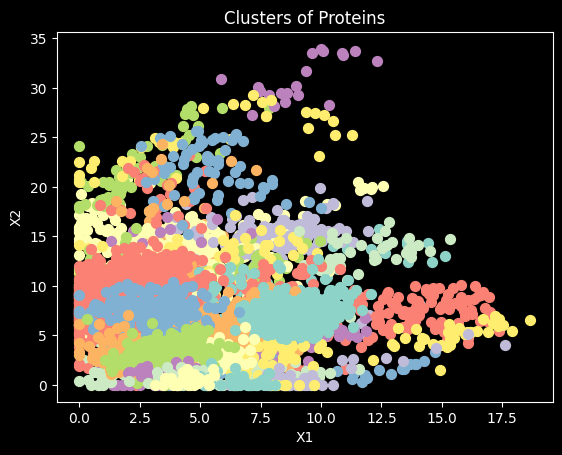

In [ ]:
dbscan_2 = HDBSCAN(min_samples=5, min_cluster_size=10)
dbscan_labels_2 = dbscan_2.fit_predict(X_encoded)

# print max number of clusters found by DBSCAN
print('Max number of clusters found by DBSCAN: ', len(np.unique(dbscan_labels_2)))

# ax = plt.gca()
# ax.set_xlim([-20, 50])
# ax.set_ylim([-30, 20])

for i in range(len(np.unique(dbscan_labels_2))):
	plt.scatter(X_encoded[dbscan_labels_2 == i, 0], X_encoded[dbscan_labels_2 == i, 1], s=50, label='Cluster ' + str(i))

plt.title('Clusters of Proteins')
plt.xlabel('X1')
plt.ylabel('X2')
# plt.legend()
plt.show()